# 1. Imports and Settings

In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns
import numpy as np
import json
import seaborn as sns

# Settings
TICKERS = ["TSLA", "BND", "SPY"]
DATA_DIR = "../data/processed"
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# 2. Load Price Data

In [40]:
def load_and_clean_price_data(tickers, data_dir=DATA_DIR):
    price_data = pd.DataFrame()
    for ticker in tickers:
        file_path = os.path.join(data_dir, f"{ticker}_processed.csv")
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        price_data[ticker] = df['Adj Close']

    # Replace inf/-inf with NaN
    price_data = price_data.replace([np.inf, -np.inf], np.nan)
    # Drop rows with NaN
    price_data = price_data.dropna(axis=0, how='any')
    # Remove rows with any zero prices to avoid inf returns
    price_data = price_data[(price_data != 0).all(axis=1)]
    return price_data

price_data = load_and_clean_price_data(TICKERS)

# 3. Data Diagnostics

Price data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2630 entries, 2015-07-01 to 2025-07-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    2630 non-null   float64
 1   BND     2630 non-null   float64
 2   SPY     2630 non-null   float64
dtypes: float64(3)
memory usage: 82.2 KB
None
Initial price data shape: (2630, 3)
Any NaNs in price data? False
Any infinite values in price data? True


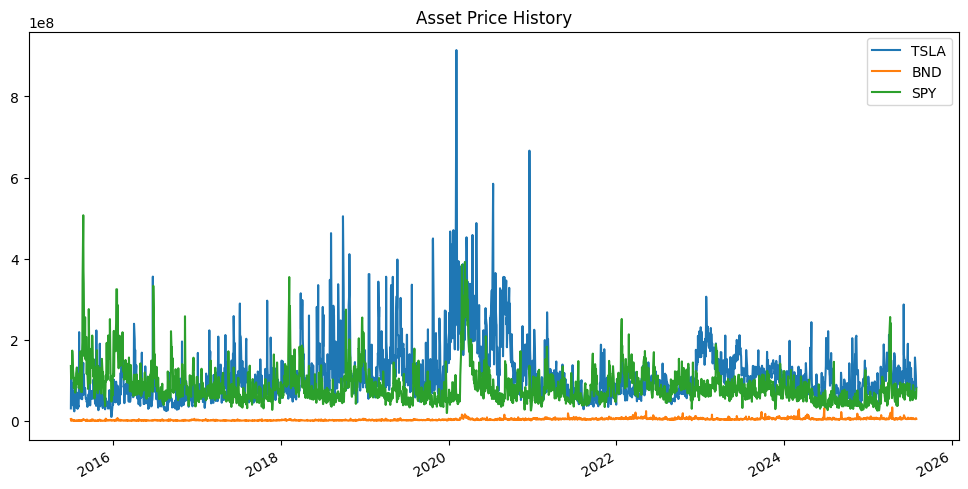

Returns stats after cleaning:
              TSLA          BND          SPY
count  2629.000000  2629.000000  2629.000000
mean      0.063305     0.076748     0.049674
std       0.439364     0.509394     0.346179
min      -0.738683    -0.833518    -0.687575
25%      -0.183672    -0.186452    -0.179245
50%      -0.013203     0.000000     0.000000
75%       0.185884     0.223777     0.210928
max       5.568608    11.180620     2.360032
Any inf/NaN in returns? False


In [41]:
print("Price data info:")
print(price_data.info())
print("Initial price data shape:", price_data.shape)
print("Any NaNs in price data?", price_data.isna().any().any())
print("Any infinite values in price data?", np.isfinite(price_data.values).all())

# Plot price history
price_data.plot(figsize=(12, 6), title="Asset Price History")
plt.show()

# Calculate returns and clean them
returns = price_data.pct_change()
returns = returns.replace([np.inf, -np.inf], np.nan).dropna()

print("Returns stats after cleaning:")
print(returns.describe())
print("Any inf/NaN in returns?", not np.isfinite(returns.values).all())

# 4. Portfolio Optimization

In [42]:
# Check and drop zero variance columns if any
zero_var_cols = price_data.columns[price_data.var() == 0]
if len(zero_var_cols) > 0:
    print(f"Dropping zero variance columns: {list(zero_var_cols)}")
    price_data = price_data.drop(columns=zero_var_cols)

# Calculate expected returns and covariance matrix
mu = expected_returns.mean_historical_return(price_data)
S = risk_models.CovarianceShrinkage(price_data).ledoit_wolf()

print("Expected Returns:\n", mu)
print("\nCovariance Matrix:\n", S)

# Optimize portfolio for max Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.6))
ef.max_sharpe(risk_free_rate=0.02)
clean_weights = ef.clean_weights()

print("Optimized weights:")
print(clean_weights)

performance = ef.portfolio_performance(verbose=True, risk_free_rate=0.02)

Expected Returns:
 TSLA    0.098432
BND     0.002722
SPY    -0.049102
dtype: float64

Covariance Matrix:
            TSLA        BND        SPY
TSLA  48.480361   1.994433   4.114083
BND    1.994433  60.872383   6.056888
SPY    4.114083   6.056888  34.827877
Optimized weights:
OrderedDict([('TSLA', 0.6), ('BND', 0.4), ('SPY', 0.0)])
Expected annual return: 6.0%
Annual volatility: 530.6%
Sharpe Ratio: 0.01


# 5. Save Portfolio Weights

In [43]:
weights_path = os.path.join(RESULTS_DIR, "portfolio_weights.json")
with open(weights_path, "w") as f:
    json.dump(clean_weights, f, indent=4)
print(f"Saved portfolio weights to {weights_path}")

Saved portfolio weights to ../results\portfolio_weights.json


# 6. Visualize Weights

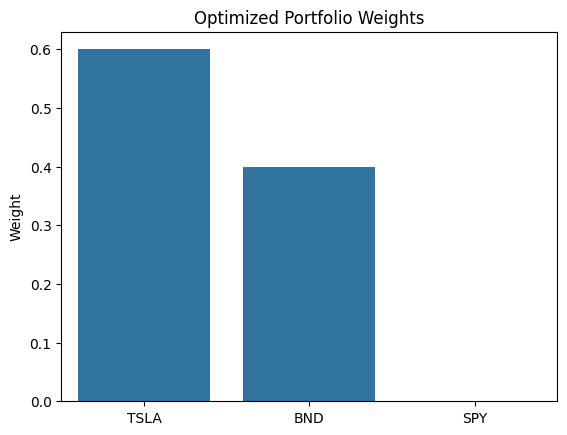

In [44]:
sns.barplot(x=list(clean_weights.keys()), y=list(clean_weights.values()))
plt.title("Optimized Portfolio Weights")
plt.ylabel("Weight")
plt.show()